In [2]:
#This is an experimental task on predicting the Initial National Demand Out-turn (INDO)
#It represents predictions done with XGBoost and Prophet models 
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
import imageio
import os
from fbprophet import Prophet

In [3]:
#INDO
df=pd.read_csv('../csv-files/INDO-2017-2019.csv',index_col=[0],parse_dates=[0])

df.head(3)

,Settlement_Period,INDO
datetime,,
2017-01-01 00:00:00,1,27239
2017-01-01 00:30:00,2,27814
2017-01-01 01:00:00,3,27453


In [20]:
df.dtypes

Settlement_Period    int64
INDO                 int64
dtype: object

In [3]:
#Splitting the data:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

def limit(data, frm, to):
    return data[(data.index>=frm)&(data.index<to)]

In [4]:
df.sort_index(inplace=True)

In [5]:
t = df.INDO.copy()
t = t.drop(t.index[t.index.duplicated()])
freq_index = pd.date_range(start=t.index[0], end=t.index[-1], freq='30T')
constructed = pd.Series(index=freq_index, name='INDO')
constructed.update(t)
constructed.interpolate(inplace=True)

In [6]:
train = limit(constructed, '2017-01-01', '2019-06-15')
test  = limit(constructed, '2019-06-15', '2019-07-01')
train.shape, test.shape

((42960,), (768,))

In [7]:
train.head()

2017-01-01 00:00:00    27239.0
2017-01-01 00:30:00    27814.0
2017-01-01 01:00:00    27453.0
2017-01-01 01:30:00    26312.0
2017-01-01 02:00:00    25289.0
Freq: 30T, Name: INDO, dtype: float64

In [8]:
df_train=df[df.index.isin(train.index)].copy()
df_test=df[df.index.isin(test.index)].copy()
df_train.shape,df_test.shape

((42954, 2), (768, 2))

In [10]:
#split_date = '15-Jun-2019 00:00'
#df_train = df.loc[df.index <= split_date].copy()
#df_test = df.loc[df.index > split_date].copy()

In [11]:
df_test.shape

(768, 2)

[Text(0, 0.5, ''), Text(0.5, 0, '')]

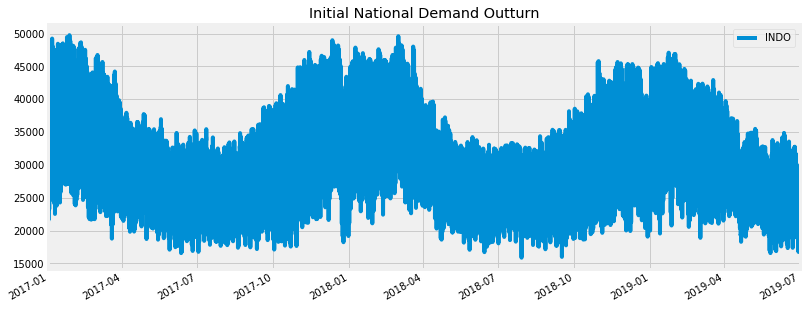

In [13]:
title = 'Initial National Demand Outturn'
ylabel=''
xlabel=''

ax = df['INDO'].plot(figsize=(12,5),title=title,legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [56]:
df['date'] = df.index
df['hour'] = df['date'].dt.hour
df['dayofweek'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['dayofyear'] = df['date'].dt.dayofyear
df['dayofmonth'] = df['date'].dt.day
df['weekofyear'] = df['date'].dt.weekofyear
    

def use_features(df):
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    return X

In [59]:
df.head(3)

,Settlement_Period,INDO,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
datetime,,,,,,,,,,,
2017-01-01 00:00:00,1,27239,2017-01-01 00:00:00,0,6,1,1,2017,1,1,52
2017-01-01 00:30:00,2,27814,2017-01-01 00:30:00,0,6,1,1,2017,1,1,52
2017-01-01 01:00:00,3,27453,2017-01-01 01:00:00,1,6,1,1,2017,1,1,52


In [57]:
X_train, y_train = use_features(df_train), df_train['INDO']
X_test, y_test   = use_features(df_test), df_test['INDO']

X_train.shape, y_train.shape, X_test.shape,y_test.shape

((42954, 8), (42954,), (768, 8), (768,))

In [32]:
#XGBoost Model:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change verbose to True if you want to see it train

C:\Users\Lenovo NBB\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Lenovo NBB\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[22:38:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

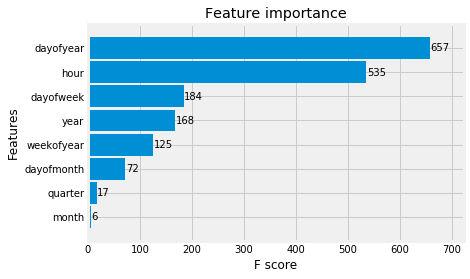

In [64]:
xgb.plot_importance(reg, height=0.9)

In [33]:
forecast_xgb= reg.predict(X_test)


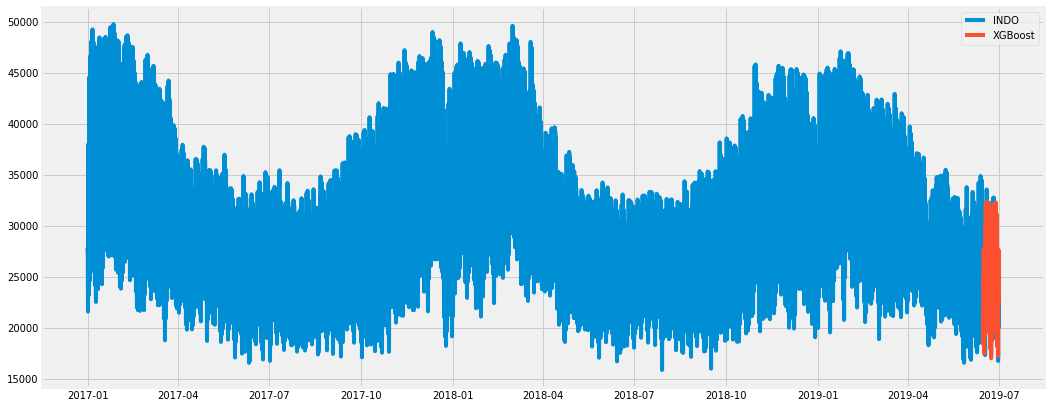

In [34]:
plt.figure(figsize=(16,7))
plt.plot(pd.concat([train,test]))
plt.plot(test.index, forecast_xgb, label='XGBoost')
plt.legend()

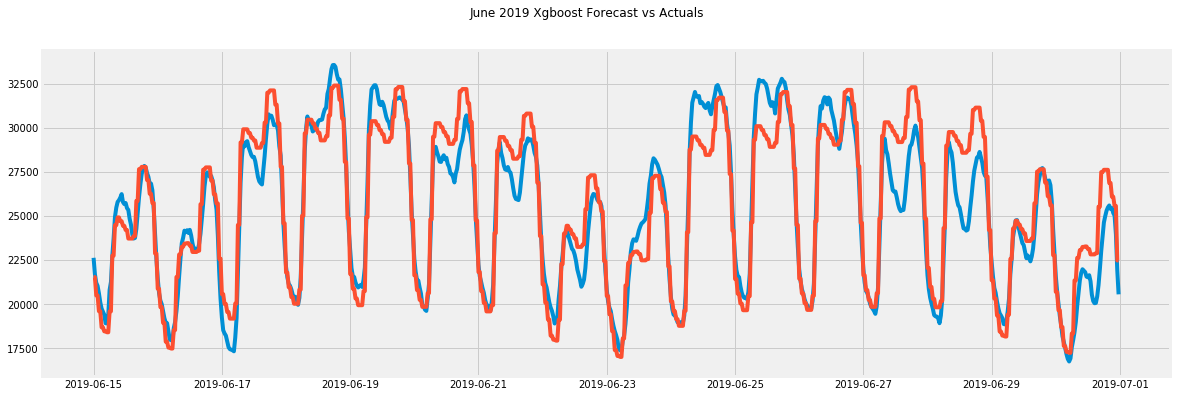

In [35]:
plt.figure(figsize=(18,6))
#plt.plot(pd.concat([train,test]))
plt.plot(test)
plt.plot(df_test.index, forecast_xgb, label='Xgboost')
plot = plt.suptitle('June 2019 Xgboost Forecast vs Actuals')

In [36]:
#Xgboost Model  evaluation:
from statsmodels.tools.eval_measures import mse,rmse
from sklearn.metrics import mean_absolute_error

error1 = mse(test, forecast_xgb)
error2 = rmse(test, forecast_xgb)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(true, pred):
    return 100/len(true) * np.sum(2 * np.abs(pred - true) / (np.abs(true) + np.abs(pred)))


print(f'MAE Error: {mean_absolute_error(test, forecast_xgb)}'), 
print(f'MAPE Error: {mean_absolute_percentage_error(test, forecast_xgb)}')
print(f'sMAPE Error: {smape(test, forecast_xgb)}')
print(f'MSE Error : {error1:11.10}')
print(f'RMSE Error: {error2:11.10}')
print()

MAE Error: 1164.0766855875652
MAPE Error: 4.580001893009998
sMAPE Error: 4.506415781671492
MSE Error : 2241044.343
RMSE Error: 1497.011805



In [37]:
#The Prophet Model:
model_P = Prophet(weekly_seasonality=True,yearly_seasonality=True, daily_seasonality=True)
#model_P = Prophet(weekly_seasonality=True, daily_seasonality=True)
model_P.add_seasonality(name="monthly", period=30.5, fourier_order=5)
model_P.fit(pd.DataFrame({'ds': train.index, 'y':train}))

C:\Users\Lenovo NBB\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [38]:
def populate_gas_val(dt):
    current_date=str(dt.date())
    return df[current_date]['Gas'][0]

#df_train_test_data=df[df.index.isin(train.index.union(test.index))].copy()

future_dates = model_P.make_future_dataframe(periods=test.shape[0],freq='30T')
#future_dates['Gas']=future_dates['ds'].apply(populate_gas_val)
results_P = model_P.predict(future_dates)
forecast_P = results_P.set_index('ds').yhat

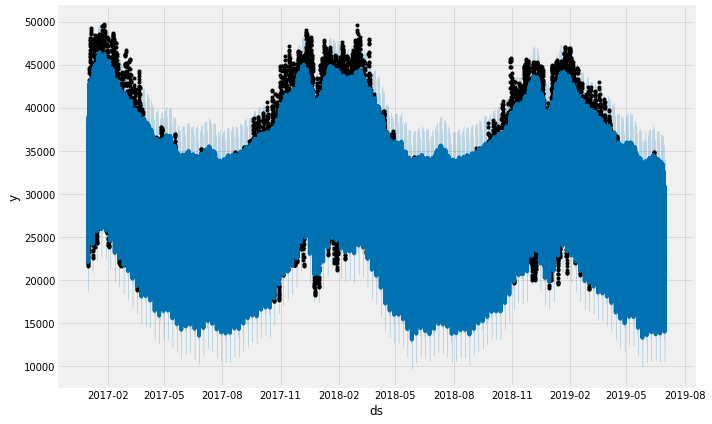

In [39]:
fig=model_P.plot(results_P)

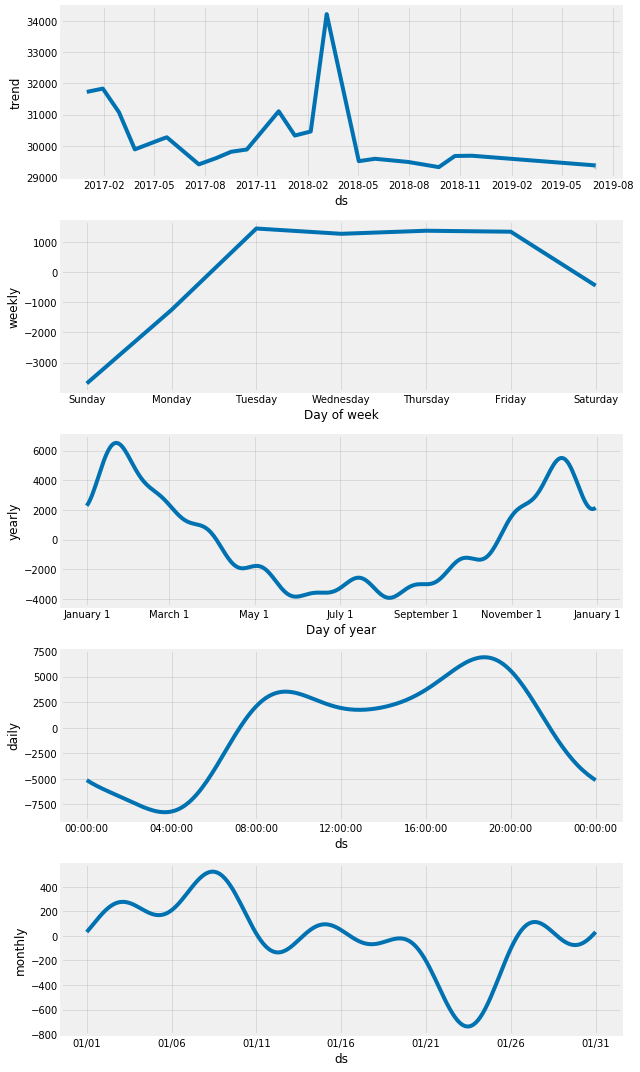

In [11]:
fig2 = model_P.plot_components(results_P)

In [51]:
test_=df[df.index.isin(test.index).copy()]
test_.shape

(768, 2)

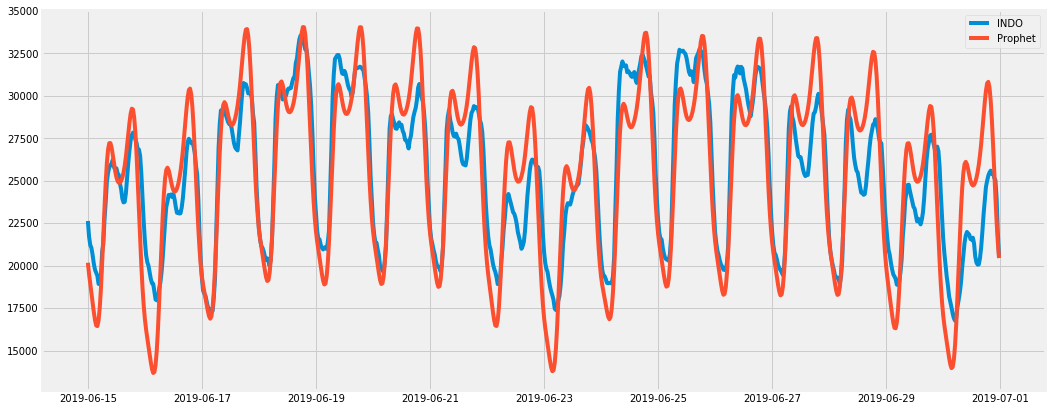

In [53]:
#The prophet model for test data and predicted values:
plt.figure(figsize=(16,7))
plt.plot(test_['INDO'])
plt.plot(test.index, forecast_P[train.shape[0]:], label='Prophet')
plt.legend()

In [54]:
#Prophet Model  evaluation:
from statsmodels.tools.eval_measures import mse,rmse
from sklearn.metrics import mean_absolute_error

error1 = mse(test, forecast_P[train.shape[0]:])
error2 = rmse(test, forecast_P[train.shape[0]:])

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f'MAE Error: {mean_absolute_error(test, forecast_P[train.shape[0]:])}'), 
print(f'MAPE Error: {mean_absolute_percentage_error(test, forecast_P[train.shape[0]:])}')
print(f'MSE Error : {error1:11.10}')
print(f'RMSE Error: {error2:11.10}')
print(forecast_P[train.shape[0]:].shape)
print(test.shape)

MAE Error: 1942.5287463398301
MAPE Error: 7.954302472652218
MSE Error : 5530777.672
RMSE Error: 2351.760547
(768,)
(768,)
